In [1]:
import torch
#import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math

#from Transformer_Model_LayerNorm import ViT
from Transformer_Model_neuron import ViT

In [2]:
import torch
import torchvision
import torchvision.transforms as tranforms
import matplotlib.pyplot as plt

mean = [0.5,0.5,0.5] #[0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
std = [0.5,0.5,0.5] #[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((mean[0],mean[1],mean[2]),
                                                        (std[0],std[1],std[2]))])
#trainset=torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainset=torchvision.datasets.CIFAR10("~/.torch", download=True)
#trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
mean = [0.5,0.5,0.5] #[0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
std = [0.5,0.5,0.5] #[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((mean[0],mean[1],mean[2]),
                                                        (std[0],std[1],std[2]))])
trainset=torchvision.datasets.CIFAR100(root='./data',train=True, download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#np.save("img_list.npy",np.array(img_index))

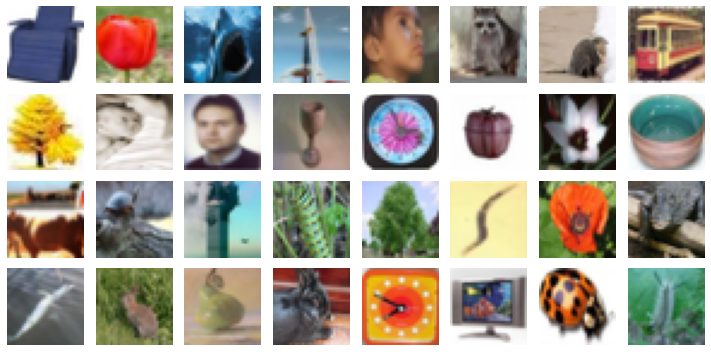

In [4]:
batch_size= 32 
index=list(np.load("img_list.npy"))
image_list=[]
sum_pix=[]
label=[]
for i in range(len(index)):
    #img =data[i] #validloader.dataset[index[i]]
    img, label2 =trainloader.dataset[index[i]]
    image_list.append(img)
    label.append(label2)
    sum_pix.append(torch.sum(img[:,0:16,16:32]))
image_list=torch.stack(image_list)

mean_inv=torch.tensor(mean).reshape(3,1,1)
std_inv=torch.tensor(std).reshape(3,1,1)
def plot_images(images, rows, cols):
    images = images.clone().detach()
    images=(images*std_inv+mean_inv).clamp(0,1)
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        #ax.imshow(images[i].transpose(1, 2, 0))
        #images[i]=images[i].reshape(3,32,32)
        ax.imshow(images[i].permute(1, 2, 0).cpu());
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(image_list,rows=4,cols=8)

In [5]:
y=label
print(y[0:8])
print(y[8:16])
print(y[16:24])
print(y[32:40])

[25, 92, 73, 76, 11, 66, 64, 81]
[47, 2, 46, 28, 22, 83, 92, 10]
[19, 93, 76, 18, 47, 99, 62, 27]
[70, 30, 8, 86, 27, 4, 42, 41]


In [6]:
RANDOM_SEED = 42
EPOCHS =  1 #40
LEARNING_RATE = 1e-4
NUM_CLASSES = 100
PATCH_SIZE = 16
IMG_SIZE = 32
CHANNELS = 3
global GLOBAL_VAR
GLOBAL_VAR=0
DROPOUT = 0 # 0.001
#HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 1
 
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 
PATCH_DIM = (PATCH_SIZE ** 2) * CHANNELS 
EMBED_DIM = (PATCH_SIZE ** 2) * CHANNELS #* (NUM_PATCHES+1)
NUM_HEADS = 12 #NUM_PATCHES+1
HEAD_DIM= EMBED_DIM//NUM_HEADS
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cpu" if torch.cuda.is_available() else "cpu"

In [7]:
# import torch
# from torchvision.models import vit_b_16
# model=vit_b_16(pretrained=True)
# w_glob=model.state_dict()
# #print(w_glob.keys())
# for key in w_glob.keys():
#     print(key)
#     print(w_glob[key].shape)

In [8]:
#from Transformer_Model import ViT
model = ViT(EMBED_DIM, PATCH_DIM, PATCH_SIZE, NUM_PATCHES,NUM_HEADS, HEAD_DIM, DROPOUT, CHANNELS, NUM_CLASSES).to(device)

#x=image_list.reshape(batch_size,1,3,32,32)
x=image_list[0].reshape(1,1,3,32,32)
# #print(x)
print(x.shape)
print(model(x).shape)

print(model.parameters)

torch.Size([1, 1, 3, 32, 32])
torch.Size([1, 768])
torch.Size([1, 100])
<bound method Module.parameters of ViT(
  (patch): Create_Patch(
    (fc1): Linear(in_features=768, out_features=768, bias=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
  )
  (mlphead): MLPHead(
    (head): Linear(in_features=768, out_features=100, bias=True)
  )
  (LN): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (encoder1): Encoder(
    (attn): Attention(
      (LN1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (QKV): Linear(in_features=768, out_features=2304, bias=True)
      (msa): Linear(in_features=768, out_features=768, bias=False)
      (relu): ReLU()
      (res): Residual()
    )
    (mlp): MLP(
      (LN2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): GELU(approximate='none')
      (relu): ReLU()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (res): Residual

In [12]:
GLOBAL_VAR=0
import copy
batch_size=32
y=label[0:batch_size] #.reshape(1)
y=torch.tensor(y)
print(type(y))
#y=torch.tensor(trainloader.dataset[index[16]][1])
print(y)
#y=y.reshape(1)
#print(y)
criterion=nn.CrossEntropyLoss()
target_gradient=copy.deepcopy(model.state_dict())
#optimizer=optim.Adam(model.parameters(), lr=1)
iter=1
#data=data.reshape(batch_size,1,3,32,32)
#x=data[2].reshape(1,1,3,32,32)
data=image_list[0:batch_size].reshape(batch_size,1,3,32,32)
#y=label.reshape(1)
for i in range(iter):
    #optimizer.zero_grad() #used to clear old gradients otherwise they will be accumulated
    #print(model.state_dict())
    model.train()
    output=model(data)
    loss=criterion(output.to(device),y.to(device))
    model.zero_grad()
    #optimizer.zero_grad()
    loss.backward()
    #optimizer.step() #used to update model parameters
    print(loss)
    #gradient = torch.autograd.grad(loss, model.parameters(), create_graph=True)
target_grad_list=[]
count=0
for name, param in model.named_parameters():
    if param.grad is not None:
        #print(f"{name}: {param.grad}")
        target_gradient[name]=param.grad
        target_grad_list.append(param.grad.view(-1))
        if name=='patch.position_embeddings':
            index=count
            gradient_pos=param.grad.view(-1)
        count+=1
            
target_grad_list=torch.cat(target_grad_list)
print(len(target_grad_list))



<class 'torch.Tensor'>
tensor([25, 92, 73, 76, 11, 66, 64, 81, 47,  2, 46, 28, 22, 83, 92, 10, 19, 93,
        76, 18, 47, 99, 62, 27, 73, 65, 57, 65, 22, 87,  7, 18])
torch.Size([32, 768])
tensor(4.8672, grad_fn=<NllLossBackward0>)
85718116


In [10]:
import time
start=time.time()
from Inversion import inversion_attack 
recovered, reconstruction_loss=inversion_attack(IMG_SIZE, model,index, target_grad_list.to(device),gradient_pos.to(device), batch_size,y,100,mean_inv, std_inv)
end=time.time()

iter: 0
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(8.1704, grad_fn=<AddBackward0>)
iter: 1
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(4.3722, grad_fn=<AddBackward0>)
iter: 2
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(2.9967, grad_fn=<AddBackward0>)
iter: 3
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(2.2141, grad_fn=<AddBackward0>)
iter: 4
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(1.7799, grad_fn=<AddBackward0>)
iter: 5
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(1.5168, grad_fn=<AddBackward0>)
iter: 6
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(1.3315, grad_fn=<AddBackward0>)
iter: 7
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(1.1827, grad_fn=<AddBackward0>)
iter: 8
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(1.0543, grad_fn=<AddBackward0>)
iter: 9
Current learning rate: 0.1
to

recon loss
tensor(-0.0759, grad_fn=<AddBackward0>)
iter: 77
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0765, grad_fn=<AddBackward0>)
iter: 78
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0771, grad_fn=<AddBackward0>)
iter: 79
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0776, grad_fn=<AddBackward0>)
iter: 80
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0782, grad_fn=<AddBackward0>)
iter: 81
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0787, grad_fn=<AddBackward0>)
iter: 82
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0792, grad_fn=<AddBackward0>)
iter: 83
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0796, grad_fn=<AddBackward0>)
iter: 84
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-0.0801, grad_fn=<AddBackward0>)
iter: 85
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(-

In [ ]:
# import time
# start=time.time()
# from Inversion2 import inversion_attack2 
# recovered, reconstruction_loss=inversion_attack2(IMG_SIZE,PATCH_SIZE, model,index1,index2, weight_grad.to(device),bias_grad.to(device), batch_size,y,1000,mean_inv, std_inv)
# end=time.time()

torch.Size([32, 3, 32, 32])


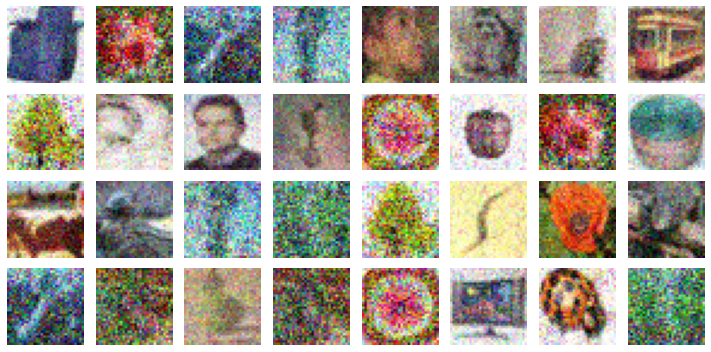

In [11]:
ans=recovered.reshape(batch_size,3,32,32) #.clamp(0,1)
print(ans.shape)
ans=ans.clone().detach()
#ans=(ans*std_inv+mean_inv).clamp(0,1)
plot_images(ans,rows=4,cols=8)
#torch.save(ans, "APRIL_64images_1500It.pt")
# plt.imshow(ans.permute(1,2,0).cpu())
# plt.axis("off")

In [ ]:
#torch.save(ans, "APRIL_32images.pt")